based on:
https://arxiv.org/abs/1511.06434
but extended with conditioning from Mirza et al. 2014

## Sources

Fractionally strided convolutions (*not* the same as deconvolutions):
- https://datascience.stackexchange.com/questions/49299/what-is-fractionally-strided-convolution-layer 
- https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

In [ ]:
import os
import time
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
#from lsun_loader import HashedLSUN

In [ ]:
t = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                        transforms.Resize((32, 32)),
                        transforms.ToTensor()])

#def lsun_std_mean():
#    dataset = HashedLSUN(root="datasets/data0", transform=t)
#    return torch.std_mean(dataset.data / 255.0)

std, mean = 0.5, 0.5

torch.manual_seed(777)
#lsun = HashedLSUN(root="datasets/data0", transform=transforms.Compose([t, transforms.Normalize(mean, std)]))

def partition(total, frac_train, frac_val, frac_test):
    """Computes integer lenghts from desired fractions."""
    val_len = int(frac_val * total)
    test_len = int(frac_test * total)
    train_len = total - test_len - val_len
    return [train_len, val_len, test_len]

#lsun_train, lsun_val, lsun_test = torch.utils.data.random_split(lsun, partition(len(lsun), 0.6, 0.1, 0.2))

mnist_train = datasets.MNIST(root="./datasets", train=True, download=True,
                             transform=transforms.Compose([transforms.Resize((32, 32)),
                                                           transforms.ToTensor(),
                                                           transforms.Normalize(std, mean)]))
mnist_test = datasets.MNIST(root="./datasets", train=False, download=True,
                             transform=transforms.Compose([transforms.Resize((32, 32)),
                                                           transforms.ToTensor(),
                                                           transforms.Normalize(std, mean)]))

## Generator

In [9]:
INIT_STD = 0.02

class DCGenerator(torch.nn.Module):
    def __init__(self, optim, nodim=100, **kwargs):
        super(DCGenerator, self).__init__()
        self.nodim = nodim

        # Formula for out shape with dilation 1:
        # (w/h_in - 1) * stride + kernel - 2*padding + output_padding

        self.linear = torch.nn.Linear(100, 8192)
        self.ct1 = torch.nn.ConvTranspose2d(512, 256, 5, stride=2, padding=2, output_padding=1)
        self.bn1 = torch.nn.BatchNorm2d(256)
        self.ct2 = torch.nn.ConvTranspose2d(266, 128, 5, stride=2, padding=2, output_padding=1)
        self.bn2 = torch.nn.BatchNorm2d(128)
        self.ct3 = torch.nn.ConvTranspose2d(128, 1, 5, stride=2, padding=2, output_padding=1)
        
        self.ct_cond = torch.nn.ConvTranspose2d(10, 10, 7, stride=2, padding=0, output_padding=1)
        self.bn_cond = torch.nn.BatchNorm2d(10)
        
        self.optim = optim(self.parameters(), **kwargs)
        
        torch.nn.init.normal_(self.linear.weight, 0, INIT_STD)
        torch.nn.init.normal_(self.ct1.weight, 0, INIT_STD)
        torch.nn.init.normal_(self.bn1.weight, 0, INIT_STD)
        torch.nn.init.normal_(self.ct2.weight, 0, INIT_STD)
        torch.nn.init.normal_(self.bn2.weight, 0, INIT_STD)
        torch.nn.init.normal_(self.ct3.weight, 0, INIT_STD)
        
        # no one said this will be good but let's try
        torch.nn.init.normal_(self.ct_cond.weight, 0, INIT_STD)
        torch.nn.init.normal_(self.bn_cond.weight, 0, INIT_STD)

    def set_optim(self, optim):
        self.optim = optim

    def forward(self, z, y):
        x = self.linear(z)
        x = torch.nn.Unflatten(1, (512, 4, 4))(x)
        x = self.ct1(x)
        x = self.bn1(x)
        x = torch.nn.ReLU()(x)
        
        # conditioning variable (here one-hot MNIST label)
        cond = y.reshape(y.shape[0], 10, 1, 1) # it this doesn't work maybe it's better to
                                               # assume that y is already (batch_size, 10, 1, 1)
        cond = self.ct_cond(cond)
        cond = self.bn_cond(cond)
        cond = torch.nn.ReLU()(cond)
        x = torch.cat((x, cond), dim=1)

        x = self.ct2(x)
        x = self.bn2(x)
        x = torch.nn.ReLU()(x)
        
        x = self.ct3(x)
        #x = self.bn3(x)
        #x = torch.nn.ReLU()(x)

        #x = self.ct4(x)
        x = torch.nn.Tanh()(x)
        return x

    def update(self, dis, z, y):
        self.optim.zero_grad()
        loss = dis.loss(dis(self(z, y), y), torch.ones(z.shape[0], 1))
        loss.backward()
        self.optim.step()
        return loss

## Discriminator

In [10]:
class DCDiscriminator(torch.nn.Module):
    def __init__(self, optim, criterion, **kwargs):
        super(DCDiscriminator, self).__init__()
        self.criterion = criterion
        
        self.conv1 = torch.nn.Conv2d(1, 16, 3, stride=1)
        self.conv2 = torch.nn.Conv2d(16, 32, 3, stride=1)
        self.conv3 = torch.nn.Conv2d(32, 32, 3, stride=2)
        self.conv4 = torch.nn.Conv2d(32, 64, 3, stride=1)
        self.conv5 = torch.nn.Conv2d(64, 128, 3, stride=1)
        self.conv6 = torch.nn.Conv2d(138, 138, 3, stride=2)
        self.linear = torch.nn.Linear(2208, 1)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.bn4 = torch.nn.BatchNorm2d(64)
        self.bn5 = torch.nn.BatchNorm2d(128)
        
        self.ct_cond = torch.nn.ConvTranspose2d(10, 10, 9, stride=2, padding=0, output_padding=0)
        self.bn_cond = torch.nn.BatchNorm2d(10)
        
        self.optim = optim(self.parameters(), **kwargs)
        
        torch.nn.init.normal_(self.conv1.weight, 0, INIT_STD)
        torch.nn.init.normal_(self.conv2.weight, 0, INIT_STD)
        torch.nn.init.normal_(self.conv3.weight, 0, INIT_STD)
        torch.nn.init.normal_(self.conv4.weight, 0, INIT_STD)
        torch.nn.init.normal_(self.conv5.weight, 0, INIT_STD)
        torch.nn.init.normal_(self.conv6.weight, 0, INIT_STD)
        
        torch.nn.init.normal_(self.bn2.weight, 0, INIT_STD)
        torch.nn.init.normal_(self.bn4.weight, 0, INIT_STD)
        torch.nn.init.normal_(self.bn5.weight, 0, INIT_STD)
        torch.nn.init.normal_(self.linear.weight, 0, INIT_STD)

    def forward(self, x, y):
        x = self.conv1(x)
        x = torch.nn.LeakyReLU(0.2)(x)
        
        x = self.conv2(x)
        x = torch.nn.LeakyReLU(0.2)(x)
        x = self.bn2(x)
        
        x = self.conv3(x)
        x = torch.nn.LeakyReLU(0.2)(x)
        
        x = self.conv4(x)
        x = torch.nn.LeakyReLU(0.2)(x)
        x = self.bn4(x)
        
        x = self.conv5(x)
        x = torch.nn.LeakyReLU(0.2)(x)
        x = self.bn5(x)
        
        # conditioning on one-hot MNIST labels
        cond = y.reshape(y.shape[0], 10, 1, 1)
        cond = self.ct_cond(cond)
        cond = self.bn_cond(cond)
        cond = torch.nn.LeakyReLU(0.2)(cond)
        x = torch.cat((x, cond), dim=1)

        x = self.conv6(x)
        x = torch.nn.LeakyReLU(0.2)(x)
        
        x = torch.nn.Flatten()(x)
        x = self.linear(x)
        x = torch.nn.Sigmoid()(x)
        return x

    def loss(self, x, y):
        return self.criterion(x, y)

    def update(self, true_sample, gen_sample, y):
        self.optim.zero_grad()

        true_loss = self.loss(self(true_sample, y), torch.ones(true_sample.shape[0], 1))
        prob = self(gen_sample, y)
        false_loss = self.loss(prob, torch.zeros(gen_sample.shape[0], 1))

        true_loss.backward()
        false_loss.backward()
        self.optim.step()
        return true_loss + false_loss, prob

## Helper functions

In [15]:
def save_examples(path, name, gen, noise_gen, cond_gen, n, **kwargs):
    noise = noise_gen(n, gen.nodim)
    examples = gen(noise, cond_gen(n))
    if not os.path.isdir(path):
        os.mkdir(path)
    torchvision.utils.save_image((std*examples + mean).detach(), fp=os.path.join(path, name), **kwargs)

def save_model(path, name, gen, dis, stats, epochs, batch_size):
    if not os.path.isdir(path):
        os.mkdir(path)
    torch.save({
        'epoch': epochs,
        'batch_size': batch_size,
        'dis_state_dict': dis.state_dict(),
        'dis_optim_state_dict': dis.optim.state_dict(),
        'gen_state_dict': gen.state_dict(),
        'gen_optim_state_dict': gen.optim.state_dict(),
        'stats': stats
    }, os.path.join(path, name))

def generate_labels(batch_size):
    ind = torch.randint(low=0, high=10, size=(batch_size,))
    res = torch.zeros((batch_size, 10))
    res[torch.arange(batch_size), ind] = 1.0
    return res

## Trainer

In [18]:
class Snapshot():
    def __init__(self, path, save_fn, period=1, name_format="%d_%d.png"):
        self.save_fn = save_fn
        self.path = path
        self.name_format = name_format
        self.period = period
    
def train(gen, dis, loader, epochs, cond_gen, noise_gen=torch.rand, fw_snapshot=None, model_snapshot=None, k=1, k2=1):
    stats = {'dis': {
        'loss': [],
        'prob': []
    }, 'gen': {
        'loss': [] 
    }}
    gen.train()
    dis.train()

    try:
        for i in range(epochs):
            pbar = tqdm(enumerate(iter(loader)), total=len(loader))
            pbar.set_description("epoch %s/%s" % (i, epochs))
            for j, (images, labels) in pbar:
                dloss, pr = 0, 0
                for _ in range(k):
                    noise = noise_gen(loader.batch_size, gen.nodim)

                    onehot_labels = torch.zeros((loader.batch_size, 10))
                    onehot_labels[torch.arange(loader.batch_size), labels] = 1.0
                    l, p = dis.update(images, gen(noise, onehot_labels), onehot_labels)
                    dloss += l
                    pr += p

                gloss = 0
                for _ in range(k2):
                    noise = noise_gen(loader.batch_size, gen.nodim)
                    # TODO: get random labels here
                    cond = cond_gen(loader.batch_size)
                    gloss += gen.update(dis, noise, cond)

                batch_prob = float(torch.mean(pr) / k)
                batch_dloss = float(torch.mean(dloss) / (2*k))
                batch_gloss = float(torch.mean(gloss) / k2)
                stats['gen']['loss'].append(batch_gloss)
                stats['dis']['prob'].append(batch_prob)
                stats['dis']['loss'].append(batch_dloss)
                #if j % 20 == 0:
                pbar.write("D(G(z)): %.2f, generator loss: %.2f, discriminator loss: %.2f" % 
                           (float(batch_prob), float(batch_gloss), float(batch_dloss)), end="\r")
                if fw_snapshot is not None:
                    if  j % fw_snapshot.period == 0:
                        fw_snapshot.save_fn(fw_snapshot.path, fw_snapshot.name_format % (i, j),
                                            gen, noise_gen=noise_gen, cond_gen=cond_gen, n=30, nrow=10, padding=0)
                if model_snapshot is not None:
                    if j % model_snapshot.period == 0:
                        model_snapshot.save_fn(model_snapshot.path, model_snapshot.name_format % j,
                                               gen, dis, stats, EPOCHS, BATCH_SIZE)
    except KeyboardInterrupt:
        if model_snapshot is not None:
            model_snapshot.save_fn(model_snapshot.path, model_snapshot.name_format % "KeyboardInterrupt", gen, dis, stats, EPOCHS, BATCH_SIZE)
    gen.eval()
    dis.eval()
    return stats

#def train(gen, dis, trainloader, epochs, prefix=None, snapshot_name="%d.png", k=1, k2=1):

In [19]:
BATCH_SIZE = 128
LR = 0.0002
BETAS = (0.5, 0.999)

dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
gen = DCGenerator(optim=torch.optim.Adam, nodim=100, lr=LR, betas=BETAS)
dis = DCDiscriminator(optim=torch.optim.Adam, criterion=torch.nn.BCELoss(), lr=LR, betas=BETAS)

In [20]:
EPOCHS=10
TIME = time.strftime("%Y-%m-%d_%H-%M", time.localtime())
fw_snapshot = Snapshot(path="images/%s" % TIME, save_fn=save_examples)
model_snapshot = Snapshot(period=100, path="models/", save_fn=save_model, name_format="dcgan_%s_%s" % (TIME, "%s"))
stats2 = train(gen, dis, dataloader, cond_gen=generate_labels, epochs=EPOCHS, noise_gen=torch.randn,
              fw_snapshot=fw_snapshot, model_snapshot=model_snapshot)

D(G(z)): 0.00, generator loss: 6.27, discriminator loss: 0.00


D(G(z)): 0.27, generator loss: 0.91, discriminator loss: 0.468


D(G(z)): 0.09, generator loss: 0.88, discriminator loss: 0.54


D(G(z)): 0.24, generator loss: 2.14, discriminator loss: 0.22


D(G(z)): 0.10, generator loss: 1.69, discriminator loss: 0.30


D(G(z)): 0.18, generator loss: 2.87, discriminator loss: 0.21


D(G(z)): 0.31, generator loss: 3.11, discriminator loss: 0.24


D(G(z)): 0.23, generator loss: 2.32, discriminator loss: 0.20


D(G(z)): 0.02, generator loss: 1.86, discriminator loss: 0.66


D(G(z)): 0.17, generator loss: 2.70, discriminator loss: 0.21


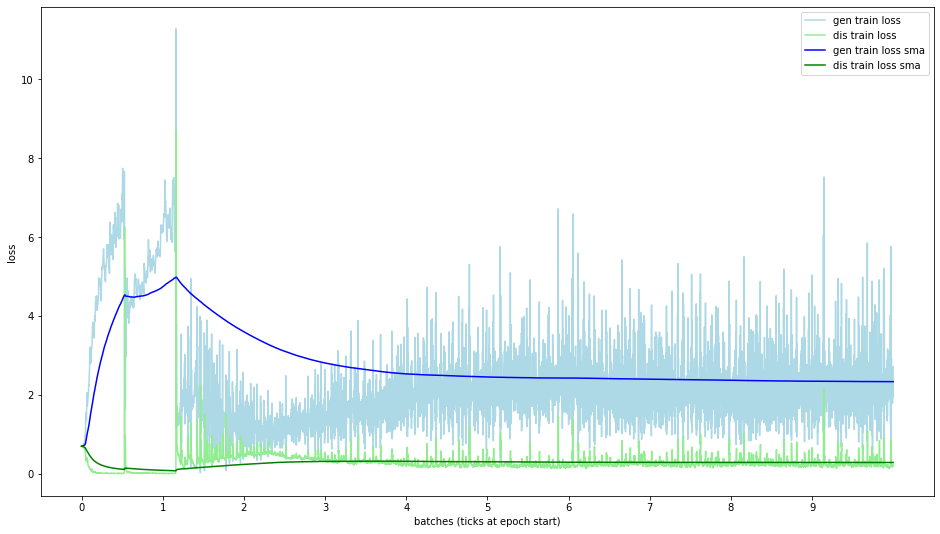

In [44]:
def sma(data):
    """Simple Moving Average."""
    result = []
    for i, x in enumerate(data):
        if result == []:
            result.append(x)
        else:
            result.append((x + ((i+1) * result[-1])) / (i+2))
    return result

def show_stats(stats, batches, epochs, step=1, draw_sma=False, draw_batches=True):
    """Rysowanie wykresów kosztu i accuracy oraz opcjonalnie średniej i branie kosztu co n-tego batcha."""
    fig, (p1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

    if draw_batches:
        p1.plot(range(0, batches * epochs, step), stats['gen']['loss'][::step], color='lightblue', label="gen train loss")
        p1.plot(range(0, batches * epochs, step), stats['dis']['loss'][::step], color='lightgreen', label="dis train loss")
    if draw_sma:
        p1.plot(range(0, batches * epochs, step), sma(stats['gen']['loss'][::step]), color='blue', label="gen train loss sma")
        p1.plot(range(0, batches * epochs, step), sma(stats['dis']['loss'][::step]), color='green', label="dis train loss sma")
    p1.set_xlabel("batches (ticks at epoch start)")
    p1.set_ylabel("loss")
    p1.set_xticks(range(0, batches * epochs, batches))
    p1.set_xticklabels(range(0, epochs))
    p1.legend()

    plt.show()

show_stats(stats2, len(dataloader), EPOCHS, step=1, draw_sma=True, draw_batches=True)

## Saving

In [21]:
save_model("models/", "cdcgan_%s_mnist_good" % TIME, gen, dis, stats2, EPOCHS, BATCH_SIZE)

In [ ]:
import imageio
with imageio.get_writer("images/%s/result_test.gif" % TIME, mode='I', duration=0.1) as writer:
    for i in range(5):
        step = i * 5 +  1
        writer._duration = 0.1 * i + 0.1
        for filename in ["images/%s/%d_%d.png" % (TIME, i, j) for j in range(0, len(dataloader), step)]:
            image = imageio.imread(filename)
            writer.append_data(image)

## Testing

tensor([[0.6041, 0.4309, 0.6955, 0.2686, 0.7513, 0.8151, 0.9868, 0.8138, 0.9274,
         0.8939, 0.9774, 0.5958, 0.7851, 0.9326, 0.9945, 0.8106]],
       grad_fn=<PermuteBackward>)


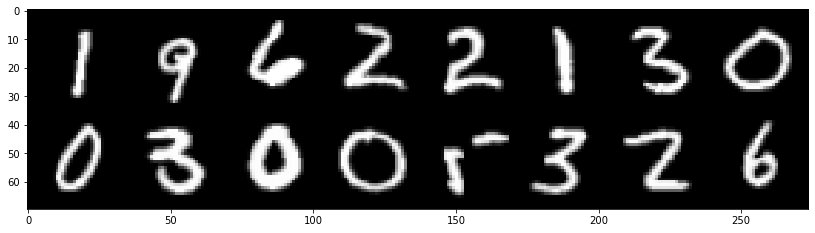

In [26]:
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=16, shuffle=True, num_workers=0)
testiter = iter(testloader)
img, labels = testiter.next()

fig, ax = plt.subplots(figsize=(14,14))
ax.imshow(torchvision.utils.make_grid(std*img + mean).detach().numpy().transpose(1, 2, 0), cmap="gray")

onehot_labels = torch.zeros((16, 10))
onehot_labels[torch.arange(16), labels] = 1.0
print(dis(img, onehot_labels).T)

tensor([[0.1538, 0.1738, 0.1349, 0.2656, 0.1526, 0.0987, 0.2679, 0.2038, 0.1402,
         0.1641, 0.1803, 0.0728, 0.1780, 0.1557, 0.1500, 0.1200]],
       grad_fn=<PermuteBackward>)


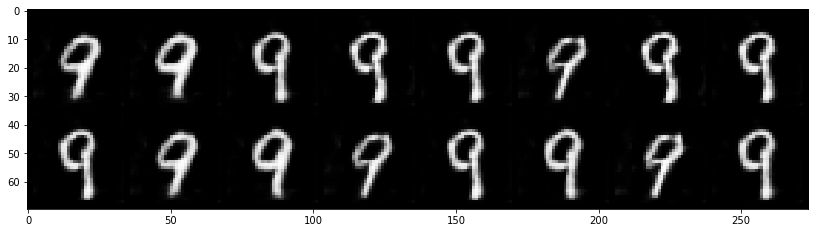

In [54]:
SAMPLE_SIZE = 16
noise = torch.randn(SAMPLE_SIZE, gen.nodim)
desired_labels = torch.zeros((SAMPLE_SIZE, 10))
desired_labels[torch.arange(SAMPLE_SIZE), 9] = 1.0
test = gen(noise, desired_labels)
fig, ax = plt.subplots(figsize=(14,14))
ax.imshow(torchvision.utils.make_grid(std*test + mean).detach().numpy().transpose(1, 2, 0), cmap="gray")

print(dis(test, desired_labels).T)

## Loading saved model

In [ ]:
# TODO: Loading model saved by save_model, such that it possible to test it (or potentially continue tranining...)

32x32 mnist works